In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Reading the data | Data Exploration
---

In [2]:
with open('taxi.json') as file:
    data = json.load(file)

In [3]:
df = pd.json_normalize(data)

In [4]:
df.head()

,amount.value,amount.precision,amount.currency,transaction_info.number,transaction_info.machine,transaction_info.timestamp,transaction_info.country,transaction_info.currency,transaction_info.partner
0,-279000,5,EUR,NaN,None,NaN,None,None,None
1,-1000000,5,EUR,NaN,None,NaN,None,None,None
2,-945000,5,EUR,NaN,None,NaN,None,None,None
3,-1100000,5,EUR,1.0,None,1.621374e+12,AT,EUR,None
4,-556000,5,EUR,NaN,None,NaN,None,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23867 entries, 0 to 23866
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amount.value                23867 non-null  int64  
 1   amount.precision            23867 non-null  int64  
 2   amount.currency             23867 non-null  object 
 3   transaction_info.number     12019 non-null  float64
 4   transaction_info.machine    0 non-null      object 
 5   transaction_info.timestamp  12019 non-null  float64
 6   transaction_info.country    10352 non-null  object 
 7   transaction_info.currency   10352 non-null  object 
 8   transaction_info.partner    0 non-null      object 
dtypes: float64(2), int64(2), object(5)
memory usage: 1.6+ MB


**'Machine' and 'partner' variable have 0 non Nan values so they will be dropped.**

In [6]:
df.describe()

,amount.value,amount.precision,transaction_info.number,transaction_info.timestamp
count,2.386700e+04,23867.0,12019.000000,1.201900e+04
mean,-1.515448e+06,5.0,2.073633,1.621902e+12
std,1.530901e+06,0.0,1.064481,3.517825e+08
min,-1.000000e+08,5.0,1.000000,1.621289e+12
25%,-1.872500e+06,5.0,1.000000,1.621593e+12
50%,-1.303000e+06,5.0,2.000000,1.621926e+12
75%,-8.900000e+05,5.0,3.000000,1.622226e+12
max,-1.000000e+03,5.0,13.000000,1.622498e+12


**Precision variable has a unique value. I will check whether other columns fall under the same category in the cleaning process.**

# Cleaning the data
---

Changing the column names for better readability.

In [7]:
df.columns = [
    'amount', 'precision', 'currency', 'number', 'machine', 
    'timestamp', 'country', 'currency_', 'partner'
]


Dropping the 'machine' and 'partner' columns.

In [8]:
df.drop(columns=['machine','partner'], inplace=True)

In [9]:
df.head()

,amount,precision,currency,number,timestamp,country,currency_
0,-279000,5,EUR,NaN,NaN,None,None
1,-1000000,5,EUR,NaN,NaN,None,None
2,-945000,5,EUR,NaN,NaN,None,None
3,-1100000,5,EUR,1.0,1.621374e+12,AT,EUR
4,-556000,5,EUR,NaN,NaN,None,None


In [10]:
columns = ['precision','currency','country','currency_']

for column in columns:
    print(df[column].unique())

[5]
['EUR']
[None 'AT']
[None 'EUR']


**All these columns seem to be unnecessary since they have only one value. All transactions took place in Vienna, Austria and the currency used for the transactions was Euro.**

In [11]:
df.drop(columns=['currency','precision','country','currency_'], inplace=True)

In [12]:
df.head(10)

,amount,number,timestamp
0,-279000,NaN,NaN
1,-1000000,NaN,NaN
2,-945000,NaN,NaN
3,-1100000,1.0,1.621374e+12
4,-556000,NaN,NaN
5,-910000,3.0,1.621352e+12
6,-1400000,2.0,1.621317e+12
7,-941000,NaN,NaN
8,-900000,NaN,NaN
9,-1900000,3.0,1.621313e+12


**After the clarifications I got in regards to the column 'number', I am now certain that it adds no value to the analysis so I am going to drop that too.**

In [13]:
df.drop(columns='number', inplace=True)

Converting the timestamp to a readable format:


In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', unit='ms')

In [15]:
df.head()

,amount,timestamp
0,-279000,NaT
1,-1000000,NaT
2,-945000,NaT
3,-1100000,2021-05-18 21:34:00
4,-556000,NaT


**Since precision was 5 for every amount value I will divide all values with -100000 in order to also get rid of the negative symbol that denotes the payment(amount of money withdrawn from the account)**

In [16]:
df['amount'] = df['amount']/-100000

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23867 entries, 0 to 23866
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   amount     23867 non-null  float64       
 1   timestamp  12019 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 373.0 KB


In [18]:
df.describe()

,amount
count,23867.000000
mean,15.154479
std,15.309014
min,0.010000
25%,8.900000
50%,13.030000
75%,18.725000
max,1000.000000


**Max and min amounts paid on taxi fare seem a little bit out of place. Maybe we have some incorrect registers in our dataset or maybe we have some rare occurances of very high and very low transactions. I will check for outliers further in the analysis.**

In [19]:
print(df['timestamp'].dt.year.unique())
print(df['timestamp'].dt.month.unique())

[  nan 2021.]
[nan  5.]


In [20]:
sorted(df['timestamp'].dt.day.unique())

[nan,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0]

**Since we only have observations from 17th May 2021 until 31st May 2021, the actual useful information that is provided by the timestamp is:**
- Calendar Day
- Hour
- Name of the Day


In [21]:
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['day_name'] = df['timestamp'].dt.day_name()

Let's check for first and last observation of transactions:

In [22]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2021-05-17 22:03:00
2021-05-31 21:55:00


**Basically our first observations starts on Monday night and ends on Monday night. So Monday night is the starting and ending point of the week. In my analysis I will use the 2 hours provided for the 17th but I will consider a full week Tuesday to Monday.**

In [23]:
df.head()

,amount,timestamp,day,hour,day_name
0,2.79,NaT,NaN,NaN,NaN
1,10.00,NaT,NaN,NaN,NaN
2,9.45,NaT,NaN,NaN,NaN
3,11.00,2021-05-18 21:34:00,18.0,21.0,Tuesday
4,5.56,NaT,NaN,NaN,NaN


---
# _What is the typical amount of money spent on taxi service?_


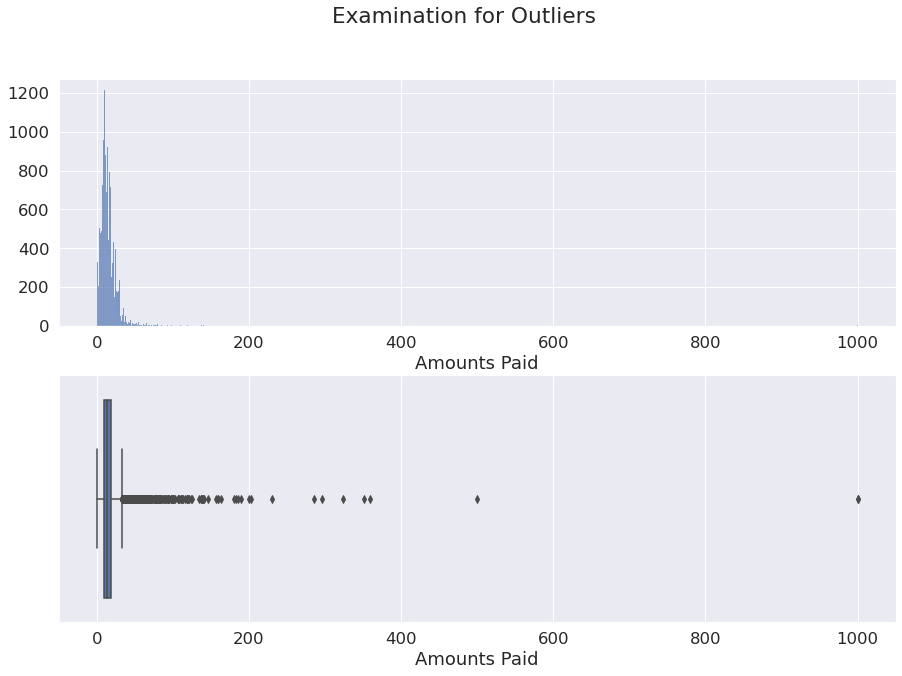

In [24]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle("Examination for Outliers")

sns.histplot(ax=axes[0], data=df, x='amount')
axes[0].set_xlabel('Amounts Paid')
axes[0].set_ylabel(None)

sns.boxplot(ax=axes[1], data=df, x='amount')
axes[1].set_xlabel('Amounts Paid')

plt.show()

#### The amount of money spent on fares seem to have many outliers that can interfere with the calculation of the typical amount spent.



Three standard deviations from the mean is a common cut-off in practice for identifying outliers. In a Guassian or Guassian-like distribution roughly 99.3% of the observed values are within 2.7 times the standard deviation and the remaining .7% are considered outliers. 

In [25]:
df1 = df.copy()

In [26]:
df1=df1[np.abs(df1['amount']-df1['amount'].mean())<=(3*df1['amount'].std())]

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23688 entries, 0 to 23865
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   amount     23688 non-null  float64       
 1   timestamp  11919 non-null  datetime64[ns]
 2   day        11919 non-null  float64       
 3   hour       11919 non-null  float64       
 4   day_name   11919 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.1+ MB


**179 outliers were removed out of 23867 transactions which is around .7% of the dataset. The occurances of these observations are so infrequent, the removal of them guarantees that they will not interfere with my statistical analysis and the general exploration on taxi usage patterns since these values do not represent the average taxi user.**

To cotinue the analysis, I will use two datasets. One with all the amount values and one with only the values that are represented by a timestamp:

In [28]:
df2 = df1.dropna()

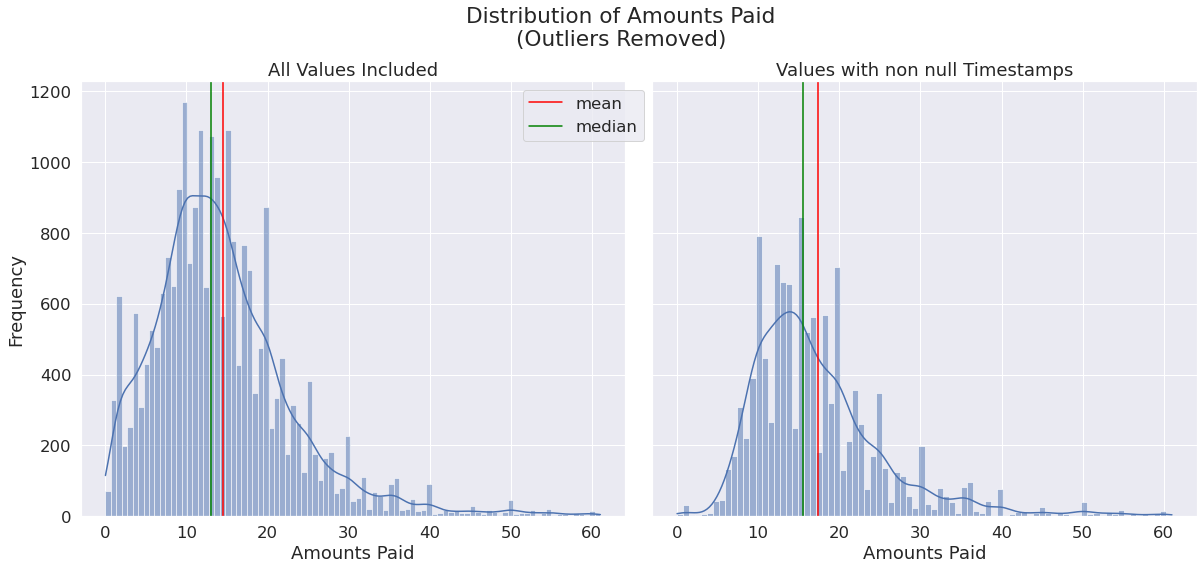

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Distribution of Amounts Paid\n(Outliers Removed)', y=1.01)
plt.subplots_adjust(wspace=0.05)

sns.histplot(ax=axes[0],data=df1, x='amount', kde=True)

sns.histplot(ax=axes[1],data=df2, x='amount', kde=True)

axes[0].axvline(x = df1.amount.mean(),color='red', label='mean')
axes[0].axvline(x = df1.amount.median(),color='green', label='median')
axes[1].axvline(x = df2.amount.mean(),color='red', label='mean')
axes[1].axvline(x = df2.amount.median(),color='green', label='median')
axes[0].set(ylabel='Frequency', xlabel='Amounts Paid')
axes[1].set(ylabel='Frequency', xlabel='Amounts Paid')
axes[0].set_title('All Values Included')
axes[1].set_title('Values with non null Timestamps')
axes[0].legend(bbox_to_anchor = (1.05,1))
plt.show()

#### **From the graph observations we can draw conclusions such:**
- There is a similar trend in amounts paid in both datasets.
- The median and mean values are fairly close to each other on each graph which means that we are approaching a symmetric Gaussian-like distribution.
- The median and mean values do not change a great deal from one dataset to another.
- The amount values with a timestamp have less observations on smaller amounts(percentagewise)

In [30]:
lower_level1 = df1['amount'].mean() - df1['amount'].std() 
upper_level1 = df1['amount'].mean() + df1['amount'].std()
lower_level2 = df2['amount'].mean() - df2['amount'].std() 
upper_level2 = df2['amount'].mean() + df2['amount'].std()

In [31]:
print(f'The most frequent amounts for the dataset with all the amount values are in the range of: ({round(lower_level1,2)} - {round(upper_level1,2)})')

The most frequent amounts for the dataset with all the amount values are in the range of: (5.73 - 23.17)


In [32]:
print(f'The most frequent amounts for the dataset with amount values represented by a timestamp are in the range of: ({round(lower_level2,2)} - {round(upper_level2,2)})')

The most frequent amounts for the dataset with amount values represented by a timestamp are in the range of: (9.03 - 25.79)


In [33]:
print('Average paying amount for all the amount values is {}'.format(df1['amount'].mean()))
print('The median observation for all the amount values is {}'.format(df1['amount'].median()))

Average paying amount for all the amount values is 14.44965425531915
The median observation for all the amount values is 13.0


In [34]:
print('Average paying amount for amount values presented by a timestamp is {}'.format(df2['amount'].mean()))
print('The median observation for mount values presented by a timestamp is {}'.format(df2['amount'].median()))

Average paying amount for amount values presented by a timestamp is 17.411227451967452
The median observation for mount values presented by a timestamp is 15.5


### _After removing the outliers we can see that the typical amount of money spent on taxi fares based on the whole dataset is around  14,5 euros with a median value of 13. It would make more sense though to use the dataset with the amount values only represented by a timestamp since our further analysis will be based on these timestamps. That means the typical amount spent on taxi fares is around 17,5 euros with a median value of 15.5_


---
# Is the typical amount affected by period of the day?

**I am going to split the day into 6 periods: midnight(00:00 - 03:59), dawn(04:00 - 07:59),  morning(08:00 - 11:59),  afternoon(12:00-15:59), evening(16:00 - 19:59) and night(20:00- 23:59).**

In [35]:
df1['period_of_day'] = pd.cut(df1['hour'], bins=6, labels=('midnight','dawn','morning','afternoon','evening','night'))

In [36]:
df1.head()

,amount,timestamp,day,hour,day_name,period_of_day
0,2.79,NaT,NaN,NaN,NaN,NaN
1,10.00,NaT,NaN,NaN,NaN,NaN
2,9.45,NaT,NaN,NaN,NaN,NaN
3,11.00,2021-05-18 21:34:00,18.0,21.0,Tuesday,night
4,5.56,NaT,NaN,NaN,NaN,NaN


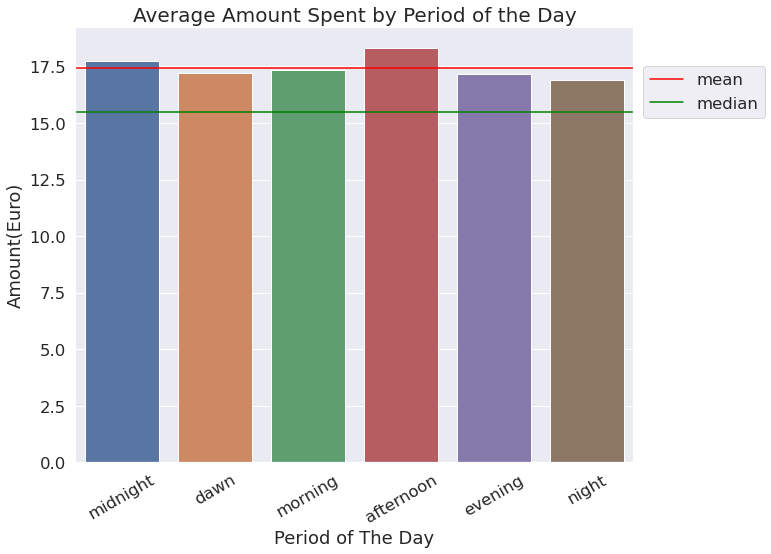

In [37]:
plt.figure(figsize=[10,8])
ax = sns.barplot(data=df1, x='period_of_day', y='amount', ci=None)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.title('Average Amount Spent by Period of the Day', fontdict={'fontsize':20})
plt.ylabel('Amount(Euro)')
plt.xlabel('Period of The Day')
plt.axhline(df2.amount.mean(), color='red',label='mean')
plt.axhline(df2.amount.median(), color='green',label='median')
plt.legend(loc=1, bbox_to_anchor=(1.25,0.93))
plt.show()

_From the graph it seems that the typical amount is not affected that much by the period of the day. Afternoon and night is a small exception since we can see a slight increase and decrease accordingly in the average amount spent. Maybe it would make more sense to examine the average amount spent by the hour._
--

In [38]:
hour=range(0,24)
labels = [str(x)+':00' for x in hour]

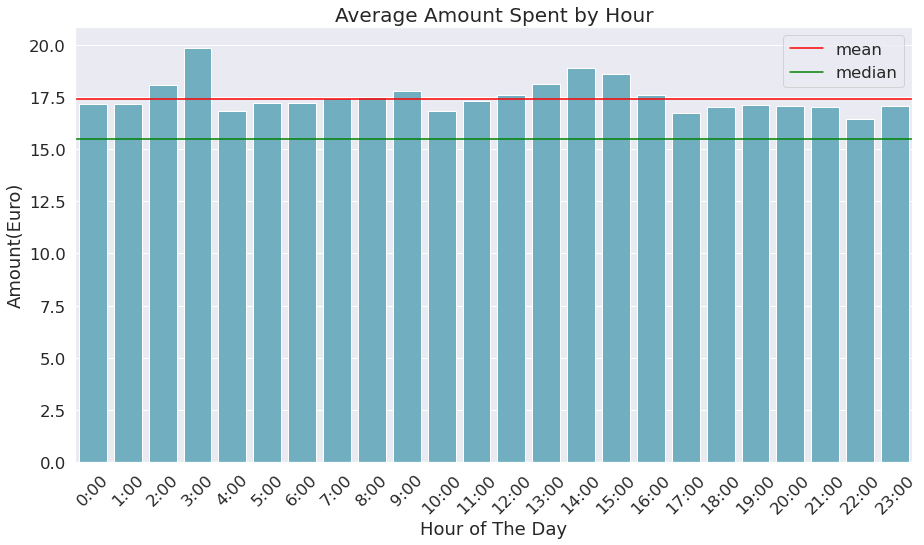

In [39]:
plt.figure(figsize=[15,8])
ax = sns.barplot(data=df2, x='hour', y = 'amount', ci=None, color='c')
ax.set_xticklabels(labels=labels,rotation=45)
plt.title('Average Amount Spent by Hour', fontdict={'fontsize':20})
plt.axhline(df2.amount.mean(), color='red',label='mean')
plt.axhline(df2.amount.median(), color='green',label='median')
plt.ylabel('Amount(Euro)')
plt.legend(loc=1)
plt.xlabel('Hour of The Day')
plt.show()

_In the graph we can observe an increase in average amount spent between 2:00 and 3:00 in the early morning as well as an increase between 13:00 and 15:00. The smallest average amount is paid at 22:00 in the night._
--

_The fact that the average amount spent by hour has no significant fluctuations and is close to the total average amount spent on taxis might be an indicator that most people use taxis for approximately the same radius. This could also be an immediate result from the fact that Vienna has great means of transportation and people use taxis only for specific routes._
--

---
# When are taxi services used most often? What can explain usage patterns?

**I will create several graphs in order to try and fully analyse the usage of taxi services.**

In [40]:
grouped = df1.groupby(['hour','day_name','day'])['amount'].count().reset_index()

In [41]:
grouped.rename({'amount':'transactions'}, axis=1, inplace=True)

In [42]:
grouped.head()

,hour,day_name,day,transactions
0,0.0,Friday,21.0,18
1,0.0,Friday,28.0,12
2,0.0,Monday,24.0,29
3,0.0,Monday,31.0,10
4,0.0,Saturday,22.0,100


In [43]:
grouped[grouped['day'] == 17]

,hour,day_name,day,transactions
310,22.0,Monday,17.0,23
324,23.0,Monday,17.0,9


I will not use the 2 hours of the 17th since it is a very small period of time that won't provide any significant insights in usage patterns.

In [44]:
grouped = grouped[grouped['day'] != 17]

**Variable preparation for the analysis with plots:**
- Splitting the dataframe into weeks
- Splitting the weeks into weekdays and weekends
- A full week is considered Tuesday to Monday so we have first week 18th to 24th of May and second week 25th to 31st of May.


In [45]:
first_week_weekends = grouped[(grouped['day'] <= 24) & (grouped['day_name'].isin(['Saturday','Sunday']))]

second_week_weekends = grouped[(grouped['day'] >= 25) & (grouped['day_name'].isin(['Saturday','Sunday']))]

first_week_weekdays = grouped[(grouped['day'] <= 24) & (~grouped['day_name'].isin(['Saturday','Sunday']))]

second_week_weekdays = grouped[(grouped['day'] >= 25) & (~grouped['day_name'].isin(['Saturday','Sunday']))]


In [46]:
weekends_first = first_week_weekends.groupby('day_name')['transactions'].sum().reset_index()

weekends_second = second_week_weekends.groupby('day_name')['transactions'].sum().reset_index()

weekdays_first = first_week_weekdays.groupby('day_name')['transactions'].sum().reset_index()

weekdays_second = second_week_weekdays.groupby('day_name')['transactions'].sum().reset_index()

In [47]:
hours_weekends_first = first_week_weekends.groupby('hour')['transactions'].sum().reset_index()

hours_weekends_second = second_week_weekends.groupby('hour')['transactions'].sum().reset_index()

hours_weekdays_first = first_week_weekdays.groupby('hour')['transactions'].sum().reset_index()

hours_weekdays_second = second_week_weekdays.groupby('hour')['transactions'].sum().reset_index()

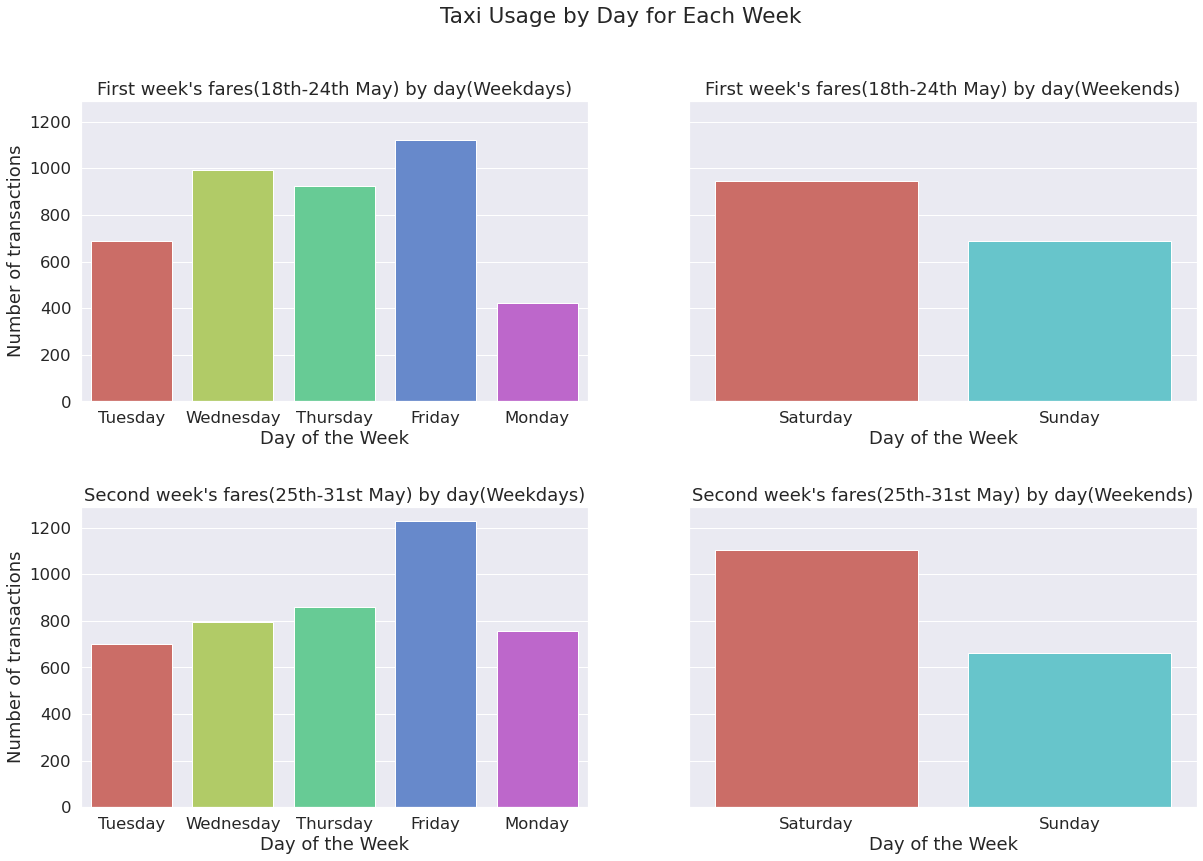

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(20, 13), sharey=True)
fig.suptitle("Taxi Usage by Day for Each Week")
plt.subplots_adjust(hspace=.35)
order = ['Tuesday','Wednesday','Thursday','Friday','Monday']

g = sns.barplot(ax = axes[0,0], data=weekdays_first, x='day_name', y ='transactions', palette='hls', order=order)

axes[0,0].set_title("First week's fares(18th-24th May) by day(Weekdays)")
axes[0,0].set_ylabel("Number of transactions")
axes[0,0].set_xlabel('Day of the Week')

g = sns.barplot(ax = axes[1,0], data=weekdays_second, x='day_name', y ='transactions', palette='hls', order=order)

axes[1,0].set_title("Second week's fares(25th-31st May) by day(Weekdays)")
axes[1,0].set_ylabel("Number of transactions")
axes[1,0].set_xlabel('Day of the Week')

g = sns.barplot(ax = axes[0,1], data=weekends_first, x='day_name', y ='transactions', palette='hls')

axes[0,1].set_title("First week's fares(18th-24th May) by day(Weekends)")
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Day of the Week')

g = sns.barplot(ax = axes[1,1], data=weekends_second, x='day_name', y ='transactions', palette='hls')

axes[1,1].set_title("Second week's fares(25th-31st May) by day(Weekends)")
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Day of the Week')

plt.show()

Usage by Day:
--
The first thing that we can notice from these set of graphs is that there is a similar trend in taxi usage for these two last weeks of May with only exception being Monday the 24th. 

After a small research I found out that Monday 24th of May 2021 was **Whit Monday** or **Pentecost Monday**, a moveable feast in the Christian liturgical calendar, which is a national holiday in Austria. That fact explains why the usage of taxis was the least out of all days' observations.  

Sundays and Tuesdays have also low taxi usage rates while Friday and Saturday have the highest. Sunday is generally observed as a day of worship(Christianity is the predominant religion in Austria) and rest(shops are closed etc.) so this would explain the low usage rates. The low usage on Tuesdays is to be further investigated. Friday and Saturday probably have the highest usage rates due to the fact that people often go out to entertain themselves(cinema, opera, bar,restaurants, etc.) after a long week's work so I am expecting the highest usage to be at late hours.

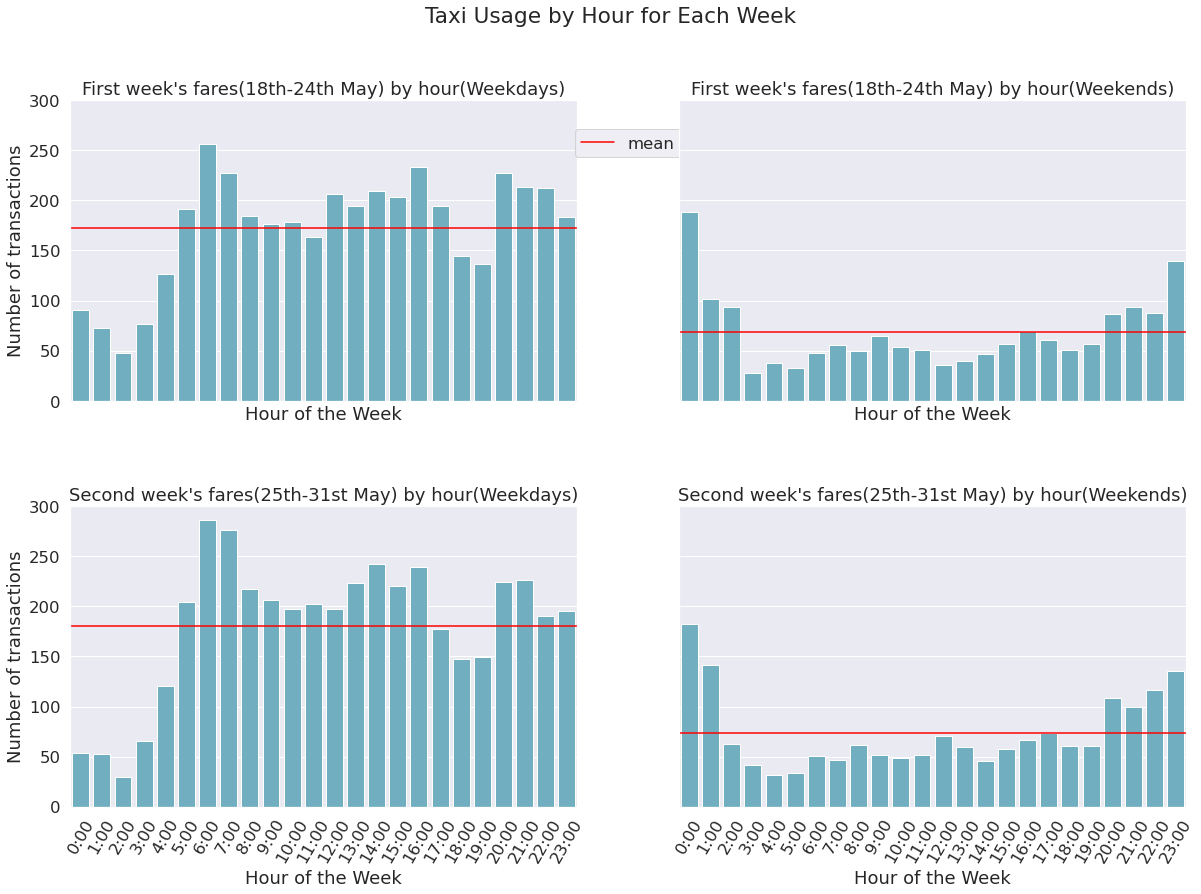

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(20, 13), sharey=True, sharex=True)
fig.suptitle("Taxi Usage by Hour for Each Week")
plt.subplots_adjust(hspace=.35)


g = sns.barplot(ax = axes[0,0], data=hours_weekdays_first, x='hour', y ='transactions', color="c")

g.set_xticks(hour)
g.set_xticklabels(labels)
axes[0,0].set_title("First week's fares(18th-24th May) by hour(Weekdays)")
axes[0,0].axhline(hours_weekdays_first.transactions.mean(), color='red', label='mean')
axes[0,0].legend(loc=1, bbox_to_anchor=(1.22,0.93))
axes[0,0].set_ylabel("Number of transactions")
axes[0,0].set_xlabel('Hour of the Week')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(),rotation=60)

g = sns.barplot(ax = axes[1,0], data=hours_weekdays_second, x='hour', y ='transactions', color="c")

g.set_xticks(hour)
g.set_xticklabels(labels)
axes[1,0].set_title("Second week's fares(25th-31st May) by hour(Weekdays)")
axes[1,0].axhline(hours_weekdays_second.transactions.mean(), color='red', label='mean')
axes[1,0].set_ylabel("Number of transactions")
axes[1,0].set_xlabel('Hour of the Week')
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(),rotation=60)

g = sns.barplot(ax = axes[0,1], data=hours_weekends_first, x='hour', y ='transactions', color="c")

g.set_xticks(hour)
g.set_xticklabels(labels)
axes[0,1].set_title("First week's fares(18th-24th May) by hour(Weekends)")
axes[0,1].axhline(hours_weekends_first.transactions.mean(), color='red', label='mean')
axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel('Hour of the Week')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(),rotation=60)

g = sns.barplot(ax = axes[1,1], data=hours_weekends_second, x='hour', y ='transactions', color="c")

g.set_xticks(hour)
g.set_xticklabels(labels)
axes[1,1].set_title("Second week's fares(25th-31st May) by hour(Weekends)")
axes[1,1].axhline(hours_weekends_second.transactions.mean(), color='red', label='mean')
axes[1,1].set_ylabel(None)
axes[1,1].set_xlabel('Hour of the Week')
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(),rotation=60)

plt.show()

Usage by Hour:
--
Again, we can see a similar trend both in weekdays and weekends in the course of these two weeks. On weekdays people tend to use the taxis earlier in the morning as well as in the early afternoon. On the weekend people use the taxis more at late hours.

**Weekdays:**
The early morning usage of taxis is most likely due to the fact that people go to work at these early hours or have general obligations(doctor's appointments, social services, etc.). Similarly, afternoon hours are the hours that people finish their obligations mentioned above so we can observe high usage there too. There is also high usage around 20:00 to 22:00 probably from people returning from outdoor activities or people who finish work later. 

**Weekends:**
Weekend usage of taxi services are fairly low with the exception of late hours (probably because of Saturday nights). It would be interesting to see how the average usage on weekends compares to the average usage on weekdays.


In [50]:
weekends = grouped[(grouped['day_name'].isin(['Saturday', 'Sunday']))].groupby('hour')['transactions'].mean().reset_index()
weekdays = grouped[~(grouped['day_name'].isin(['Saturday', 'Sunday']))].groupby('hour')['transactions'].mean().reset_index()

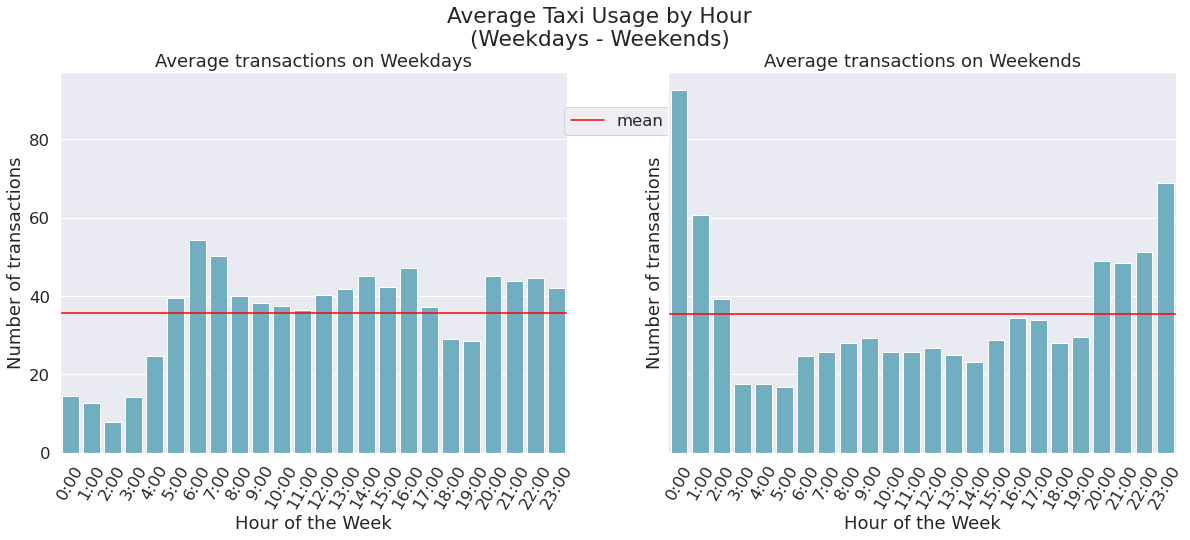

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True, sharex=True)
fig.suptitle("Average Taxi Usage by Hour\n(Weekdays - Weekends)", y=1.01)
plt.subplots_adjust(hspace=.35)


g = sns.barplot(ax = axes[0], data=weekdays, x='hour', y ='transactions', color="c")

g.set_xticks(hour)
g.set_xticklabels(labels)
axes[0].set_title("Average transactions on Weekdays")
axes[0].axhline(weekdays.transactions.mean(), color='red', label='mean')
axes[0].legend(loc=1, bbox_to_anchor=(1.22,0.93))
axes[0].set_ylabel("Number of transactions")
axes[0].set_xlabel('Hour of the Week')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=60)

g = sns.barplot(ax = axes[1], data=weekends, x='hour', y ='transactions', color="c")

g.set_xticks(hour)
g.set_xticklabels(labels)
axes[1].set_title("Average transactions on Weekends")
axes[1].axhline(weekends.transactions.mean(), color='red', label='mean')
axes[1].set_ylabel("Number of transactions")
axes[1].set_xlabel('Hour of the Week')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=60)

plt.show()

Average Usage by Hour(Weekdays - Weekends):
---
As expected, during the day the average taxi usage is higher on weekdays where people are busy with work and the shops are open. The average usage at night is much higher on weekends since people tend to go out on Saturdays.

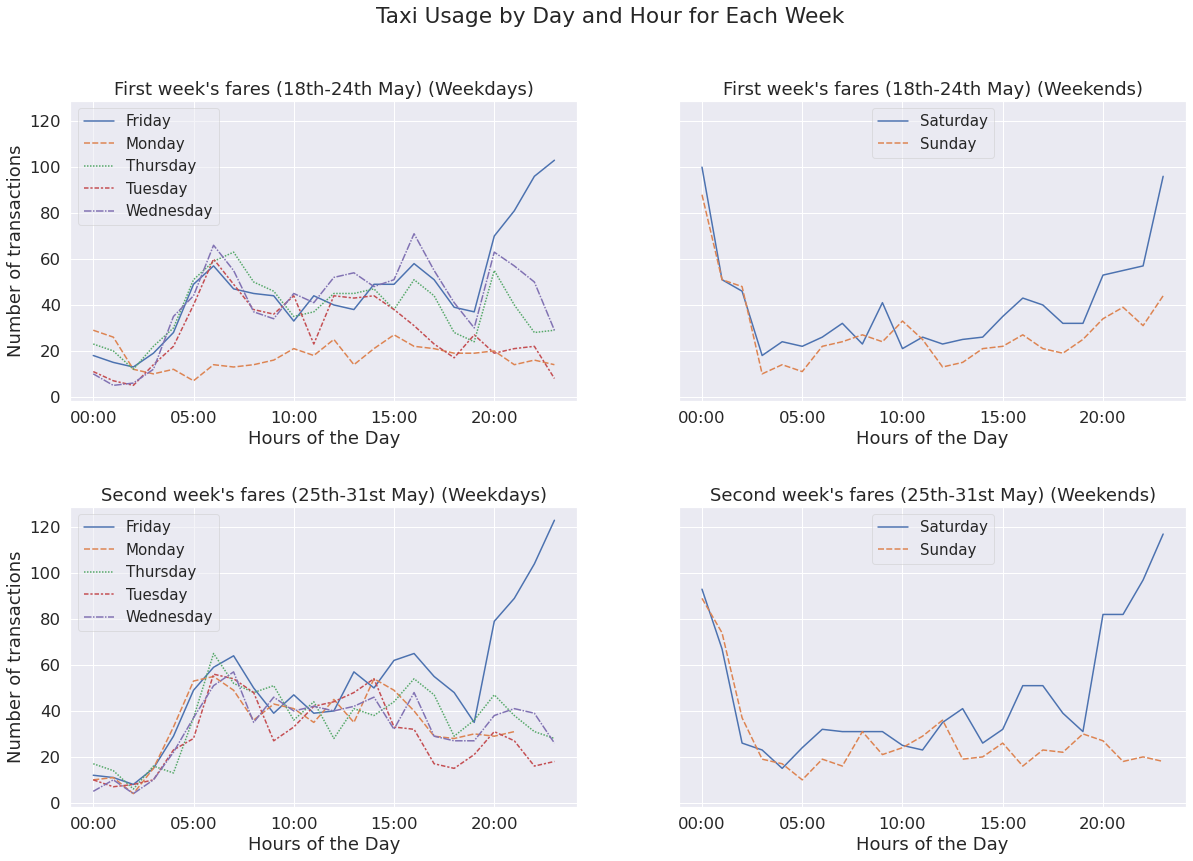

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(20, 13), sharey=True)
fig.suptitle("Taxi Usage by Day and Hour for Each Week")
plt.subplots_adjust(hspace=.35)

hour_range = [0, 5, 10, 15, 20]
labels1 = ['00:00','05:00','10:00','15:00','20:00']

g = sns.lineplot(ax = axes[0,0], data=first_week_weekdays.sort_values(by='day_name'), x='hour', 
                                                            y ='transactions', hue='day_name',style='day_name')
g.legend(framealpha=0.5, fontsize=15, loc='upper left')
g.set_xticks(hour_range)
g.set_xticklabels(labels1)
axes[0,0].set_title("First week's fares (18th-24th May) (Weekdays)")
axes[0,0].set_ylabel("Number of transactions")
axes[0,0].set_xlabel('Hours of the Day')

g = sns.lineplot(ax = axes[1,0], data=second_week_weekdays.sort_values(by='day_name'), x='hour', 
                                                            y ='transactions', hue='day_name',style='day_name')
g.legend(framealpha=0.5, fontsize=15, loc='upper left')
g.set_xticks(hour_range)
g.set_xticklabels(labels1)
axes[1,0].set_title("Second week's fares (25th-31st May) (Weekdays)")
axes[1,0].set_ylabel("Number of transactions")
axes[1,0].set_xlabel('Hours of the Day')

g = sns.lineplot(ax = axes[0,1], data=first_week_weekends.sort_values(by='day_name'), x='hour', 
                                                            y ='transactions', hue='day_name',style='day_name')
g.legend(framealpha=0.5, fontsize=15, loc='upper center')
g.set_xticks(hour_range)
g.set_xticklabels(labels1)
axes[0,1].set_title("First week's fares (18th-24th May) (Weekends)")
axes[0,1].set_xlabel('Hours of the Day')

g = sns.lineplot(ax = axes[1,1], data=second_week_weekends.sort_values(by='day_name'), x='hour', 
                                                            y ='transactions', hue='day_name',style='day_name')
g.legend(framealpha=0.5, fontsize=15, loc='upper center')
g.set_xticks(hour_range)
g.set_xticklabels(labels1)
axes[1,1].set_title("Second week's fares (25th-31st May) (Weekends)")
axes[1,1].set_xlabel('Hours of the Day')

plt.show()

Usage by Day and Hour for each week:
--
In these final graphs we can clearly see the trends of the days for the two final weeks of May. A very high usage of taxis on Friday and Saturday nights becomes apparent which strengthens my hypothesis of people going out for entertainment purposes. We can also observe the abnormal low usage on Monday the 24th due to the national holiday. 

Although the weekdays seem to follow a similar pattern, Tuesday has a drop in taxi usage on early afternoon when the other days have a small peak (Monday the 31st has a drop too but in general ther usage is higher than Tuesday). This is probably the reason why Tuesday has the lowest taxi usage rate as we saw in the first set of graphs (Monday the 24th excluded).


# Conclusions for these last two weeks of May:


- **The typical amount spent on taxi services is around 17,5 euros.**
- **This typical amount is not severely affected by the period of the day. This can mean that people use taxis for approximately the same distances.**
- **Monday the 24th was a national holiday that is why it had the lowest taxi usage rate.**
- **Friday and Saturday nights had the highest number of transactions during the course of these two weeks probably because these are the days and hours that people tend to go out in the course of the week.**
- **During the weekdays taxi usage rates follows a similar pattern with a small deviance on Tuesday.**